Data uploading

In [87]:
from google.colab import files
uploaded = files.upload()

Saving IBM_2006-01-01_to_2018-01-01.csv to IBM_2006-01-01_to_2018-01-01 (1).csv


Library loading

In [88]:
import collections
import sys
import os
import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

from plotly.offline import init_notebook_mode, iplot
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

Plotly code

In [89]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [90]:
df = pd.read_csv(io.BytesIO(uploaded['IBM_2006-01-01_to_2018-01-01.csv']))
df = df.drop('Name', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3020 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3020 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3020 non-null   float64
 5   Volume  3020 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 141.7+ KB


In [101]:
training_set = df.loc[:'2016'].iloc[:, 1:2].values
test_set = df.loc['2017':].iloc[:, 1:2].values

Data visualization

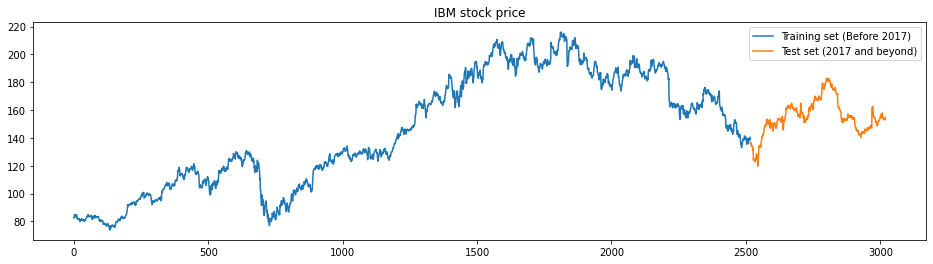

In [102]:
df["High"][df['Date'] <= '2016'].plot(figsize=(16,4),legend=True)
df["High"][df['Date'] > '2016'].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

Data training

In [103]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [104]:
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [120]:
X_train = []
y_train = []

for i in range(60, 2017):
    X_train.append(training_set_scaled[i - 60 : i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [124]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [125]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
62/62 [==============================] - 11s 81ms/step - loss: 0.0437
Epoch 2/50
62/62 [==============================] - 5s 86ms/step - loss: 0.0092
Epoch 3/50
62/62 [==============================] - 5s 86ms/step - loss: 0.0096
Epoch 4/50
62/62 [==============================] - 5s 86ms/step - loss: 0.0075
Epoch 5/50
62/62 [==============================] - 5s 86ms/step - loss: 0.0075
Epoch 6/50
62/62 [==============================] - 5s 87ms/step - loss: 0.0080
Epoch 7/50
62/62 [==============================] - 5s 85ms/step - loss: 0.0068
Epoch 8/50
62/62 [==============================] - 5s 87ms/step - loss: 0.0052
Epoch 9/50
62/62 [==============================] - 5s 87ms/step - loss: 0.0049
Epoch 10/50
62/62 [==============================] - 5s 87ms/step - loss: 0.0048
Epoch 11/50
62/62 [==============================] - 5s 87ms/step - loss: 0.0042
Epoch 12/50
62/62 [==============================] - 5s 88ms/step - loss: 0.0041
Epoch 13/50
62/62 [=================

In [128]:
dataset_total = pd.concat((df['High'][df['Date'] <= '2016'], df['High'][df['Date'] > '2016']),axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [134]:
X_test = []
for i in range(60, 1063):
    X_test.append(inputs[i - 60: i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [135]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

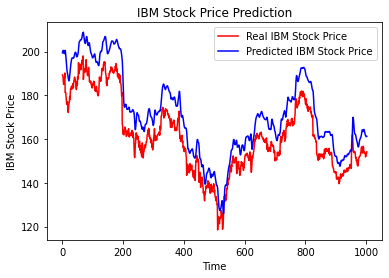

In [138]:
plot_predictions(test_set, predicted_stock_price)